In [1]:
"""
* Data used to train this model is taken from NASA website and prepared accordingly
* Details regarding data preperation are present in the 'ReadMe.docx' file in the folder "Train Samples"
* Charge Curves data is used to estimate SoH of the battery.Data was collected under different conditions which 
  are mentioned in the "Selected Samples.xlsx" file  
* Partial Charge curves are created to train the CNN model
* NASAData Model-2.h5 can be used to show the results. 
"""

'\n* Data used to train this model is taken from NASA website and prepared accordingly\n* Details regarding data preperation are present in the \'ReadMe.docx\' file in the folder "Train Samples"\n* Charge Curves data is used to estimate SoH of the battery.Data was collected under different conditions which \n  are mentioned in the "Selected Samples.xlsx" file  \n* Partial Charge curves are created to train the CNN model\n* \n'

In [25]:
from __future__ import absolute_import, division, print_function, unicode_literals

                  #handling data
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
                 #scaling and splitting data
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
                #build and train model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,Dense,Flatten,GlobalMaxPooling2D,BatchNormalization,MaxPooling2D,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
                #save and load the model
from tensorflow.keras.models import load_model
                #evaluate model
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from scipy.stats import zscore
from sklearn.model_selection import KFold



import random
from random import seed, uniform, randint


import sys
sys.setrecursionlimit(10000)    #used to increase the recursion limit.



In [323]:
#training  input data
train_indata = pd.ExcelFile("C:\\Users\\Soongsil Univ\\Documents\\Pradyumna\\NASA Cells\\Train Samples\\Total Charge Train Data.xlsx")
# training output data
train_outdata =  pd.read_excel("C:\\Users\\Soongsil Univ\\Documents\\Pradyumna\\NASA Cells\\Train Samples\\Capacity Output Train Data.xlsx")

#testing  input data
test_indata = pd.ExcelFile("C:\\Users\\Soongsil Univ\\Documents\\Pradyumna\\NASA Cells\\Train Samples\\Charge 31 Test.xlsx")
# testing output data
test_outdata =  pd.read_excel("C:\\Users\\Soongsil Univ\\Documents\\Pradyumna\\NASA Cells\\Train Samples\\Capacity Output-31.xlsx", header=None)

In [251]:
                        # Creating partial charge curves data for Training Data 

train_data_in = {}              # new empty dictionary
for sheet in train_indata.sheet_names:
    train_data_in[sheet] = pd.read_excel(train_indata, sheet) # Storing the total data sheet by sheet into a dictionary   

seed(10)             # to get same random number always
train_input = {}           # new empty dictionary
for sheet in train_data_in:
    p = round(uniform(0.2, 0.8), 2)                  # generate a random number between 0.2 and 0.8 with 2 decimal places
    length = int(round(train_data_in[sheet].shape[0] * p, 0))  # get the number of rows to be obtained with the percentage value of 'p'
    start = randint(0, train_data_in[sheet].shape[0] - length) # selecting a random row number to start taking the rows   
    train_input[sheet] = train_data_in[sheet].loc[train_data_in[sheet].index[start:start + length], :] # copying the rows into another dictionary 

copy1 = train_input.copy()      # making a copy of the dictionary 'input_data' 
   

In [252]:
copy1      # Contains randomly selected partial charge curves

{'Sheet1':       Voltage   Current  Temperature      Time
 219  4.207053  1.320489    27.407519   822.844
 220  4.206959  1.307257    27.409753   828.610
 221  4.206549  1.299203    27.415878   834.469
 222  4.207099  1.298662    27.424552   840.282
 223  4.206854  1.291002    27.429006   846.188
 ..        ...       ...          ...       ...
 640  4.205832  0.058952    24.252137  5169.516
 641  4.205475  0.055591    24.257282  5183.907
 642  4.205810  0.055612    24.251977  5198.250
 643  4.205956  0.057199    24.256187  5212.735
 644  4.205798  0.061579    24.253021  5227.188
 
 [426 rows x 4 columns],
 'Sheet2':       Voltage   Current  Temperature      Time
 7    3.501851  1.512180    29.283951    19.906
 8    3.511437  1.510167    29.263795    22.797
 9    3.520411  1.511072    29.243620    25.672
 10   3.529100  1.511027    29.221714    28.562
 11   3.537380  1.511571    29.195464    31.453
 ..        ...       ...          ...       ...
 463  4.131268  1.510211    28.069181  27

In [253]:
 # Creating partial charge curves data for Testing Data 

test_data_in = {}              # new empty dictionary
for sheet in test_indata.sheet_names:
    test_data_in[sheet] = pd.read_excel(test_indata, sheet) # Storing the total data sheet by sheet into a dictionary   

seed(50)             # to get same random number always
test_input = {}           # new empty dictionary
for sheet in test_data_in:
    p = round(uniform(0.2, 0.8), 2)                  # generate a random number between 0.2 and 0.8 with 2 decimal places
    length = int(round(test_data_in[sheet].shape[0] * p, 0))  # get the number of rows to be obtained with the percentage value of 'p'
    start = randint(0, test_data_in[sheet].shape[0] - length) # selecting a random row number to start taking the rows   
    test_input[sheet] = test_data_in[sheet].loc[test_data_in[sheet].index[start:start + length], :] # copying the rows into another dictionary 

copy2 = test_input.copy()      # making a copy of the dictionary 'input_data' 

In [254]:
test_input   # Contains randomly selected partial charge curves

{'Sheet1':        Voltage   Current  Temperature      Time
 545   3.925677  1.491665    44.460413  1367.844
 546   3.925796  1.491830    44.459686  1370.312
 547   3.926121  1.491722    44.458463  1372.781
 548   3.926389  1.491783    44.454046  1375.265
 549   3.926365  1.493519    44.451210  1377.797
 ...        ...       ...          ...       ...
 2332  4.213474  0.117025    44.251274  6288.797
 2333  4.213421  0.116779    44.252437  6291.719
 2334  4.213512  0.116742    44.247488  6294.734
 2335  4.213598  0.116164    44.244335  6297.719
 2336  4.211896  0.093875    44.247371  6300.719
 
 [1792 rows x 4 columns],
 'Sheet2':        Voltage   Current  Temperature      Time
 1824  4.211973  0.372684    44.593788  4855.891
 1825  4.212149  0.371827    44.585116  4858.953
 1826  4.212130  0.371518    44.585626  4861.969
 1827  4.212189  0.371339    44.594059  4865.016
 1828  4.212283  0.370699    44.589612  4868.078
 ...        ...       ...          ...       ...
 3283  4.207020 -0.00

In [255]:
# Creating input data fro training with data taken from 1st row of each of the 25 segments

for sheet in train_input:
    x = ( round((len(train_input[sheet]))/4) )  # Dividiing the partial charge curve into 5 equal parts 
                                             

    train_input[sheet] = train_input[sheet][0::x]    # taking the values of the 1st row of each part
    train_input[sheet]['D'] = ""                     # adding a new empty column in each sheet 

### D = delta(t)/delta(v) or (dt/dv) for each segment in the partial charge curve.     
    

C:\Users\SOONGS~1\AppData\Local\Temp/ipykernel_792/4116072327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[sheet]['D'] = ""                     # adding a new empty column in each sheet


In [256]:
# Creating test input data for testing with data taken from 1st row of each of the 25 segments

for sheet in test_input:
    x = ( round((len(test_input[sheet]))/4) ) 
                                             

    test_input[sheet] = test_input[sheet][0::x]   
    test_input[sheet]['D'] = ""  

C:\Users\SOONGS~1\AppData\Local\Temp/ipykernel_792/2994137917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[sheet]['D'] = ""


In [257]:
train_input   # Contains the starting data of each segment. so only 25 rows in each sheet 

{'Sheet1':       Voltage   Current  Temperature      Time D
 219  4.207053  1.320489    27.407519   822.844  
 325  4.208571  0.656402    26.166965  1567.391  
 431  4.204826  0.294138    25.063920  2541.782  
 537  4.206282  0.140063    24.486607  3748.000  
 643  4.205956  0.057199    24.256187  5212.735  ,
 'Sheet2':       Voltage   Current  Temperature      Time D
 7    3.501851  1.512180    29.283951    19.906  
 122  3.857803  1.511996    27.156487   385.922  
 237  3.941115  1.513077    26.455395   914.250  
 352  4.009209  1.510730    26.770123  1730.500  
 467  4.137376  1.511401    28.117419  2819.547  ,
 'Sheet3':       Voltage   Current  Temperature      Time D
 503  4.196640  1.511086    28.951499  3215.797  
 578  4.209064  0.641726    27.597574  4179.422  
 653  4.205674  0.267799    26.014588  5271.297  
 728  4.205693  0.129264    25.220057  6471.016  ,
 'Sheet4':       Voltage   Current  Temperature      Time D
 82   3.827106  1.510111    27.780936   246.687  
 243  3

In [258]:
# Train Data -  Adding dv/dt in the new column 'D' for each segment  

for sheet in copy1:    
        l = ( round((len(copy1[sheet]))/4) )
        
        for j in range (1,5):
            if j == 4:
                m = copy1[sheet]['Time'].iloc[-1]       # get the last value in time coulmn in the sheet from copy1 dictionary
                n = train_input[sheet]['Time'].iloc[-1] # get the last value in time coulmn in the sheet from train_input 
                v = copy1[sheet]['Voltage'].iloc[-1] - train_input[sheet]['Voltage'].iloc[-1]    #dv
                t = m-n    #dt 
            else:
                m = copy1[sheet]['Time'].iloc[j*l-1]   # get the last value from the time column of the jth segment 
                n = train_input[sheet]['Time'].iloc[j-1] # get the 1st value from the time column of the jth segment
                v = copy1[sheet]['Voltage'].iloc[j*l-1] - train_input[sheet]['Voltage'].iloc[j-1]   #dv
                t = m-n   #dt
            if v<0.0001:
                dv = 0.0001
            else:
                dv = v
            if t==0:
                dt = 1
            else:
                dt = t
          
            train_input[sheet]['D'].iloc[j-1] = dv/dt   # for every segment, store dv/dt value in the column 'D'

for sheet in train_input: 
    train_input[sheet] = train_input[sheet].drop('Time',axis=1)
    train_input[sheet] = train_input[sheet].iloc[0:4]  # to ensure there are only 25 values in each sheet 
    train_input[sheet] = train_input[sheet][["Voltage","D","Current","Temperature"]]
train_input

C:\Users\Soongsil Univ\anaconda3\envs\Pradyumna\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


{'Sheet1':       Voltage         D   Current  Temperature
 219  4.207053  0.000002  1.320489    27.407519
 325  4.208571       0.0  0.656402    26.166965
 431  4.204826  0.000001  0.294138    25.063920
 537  4.206282  0.000007  0.140063    24.486607,
 'Sheet2':       Voltage         D   Current  Temperature
 7    3.501851  0.000981  1.512180    29.283951
 122  3.857803  0.000158  1.511996    27.156487
 237  3.941115  0.000083  1.513077    26.455395
 352  4.009209    0.0001  1.510730    26.770123,
 'Sheet3':       Voltage         D   Current  Temperature
 503  4.196640  0.000013  1.511086    28.951499
 578  4.209064       0.0  0.641726    27.597574
 653  4.205674       0.0  0.267799    26.014588
 728  4.205693  0.000001  0.129264    25.220057,
 'Sheet4':       Voltage         D   Current  Temperature
 82   3.827106  0.000163  1.510111    27.780936
 243  3.940983  0.000089  1.512511    26.535252
 404  4.051552  0.000087  1.511845    27.399835
 565  4.209287       0.0  0.728121    27.8901

                                     #testing the logic to get dv/dt correctly for each segment
l = ( round((len(copy1['Sheet6']))/25) )
        
for j in range (1,26):
    if j == 25:
        m = copy1['Sheet6']['Time'].iloc[-1]       # get the last value in time coulmn in the sheet from copy1 dictionary
        n = train_input['Sheet6']['Time'].iloc[-1] # get the last value in time coulmn in the sheet from train_input 
        v1 = copy1['Sheet6']['Voltage'].iloc[-1]
        v2 = train_input['Sheet6']['Voltage'].iloc[-1]
        v = v1-v2   #dv
        t = m-n    #dt 
    else:
        m = copy1['Sheet6']['Time'].iloc[j*l-1]   # get the last value from the time column of the jth segment 
        n = train_input['Sheet6']['Time'].iloc[j-1] # get the 1st value from the time column of the jth segment
        v1 = copy1['Sheet6']['Voltage'].iloc[j*l-1]
        v2 = train_input['Sheet6']['Voltage'].iloc[j-1]
        v = v1-v2   #dv
        t = m-n   #dt
 
    print(l,j,n,m,v1,v2)

In [259]:
# Test Data -  Adding dv/dt in the new column 'D' for each segment  

for sheet in copy2:    
        l = ( round((len(copy2[sheet]))/4) )
        
        for j in range (1,5):
            if j == 4:
                m = copy2[sheet]['Time'].iloc[-1]       # get the last value in time coulmn in the sheet from copy1 dictionary
                n = test_input[sheet]['Time'].iloc[-1] # get the last value in time coulmn in the sheet from train_input 
                v = copy2[sheet]['Voltage'].iloc[-1] - test_input[sheet]['Voltage'].iloc[-1]    #dv
                t = m-n    #dt 
            else:
                m = copy2[sheet]['Time'].iloc[j*l-1]   # get the last value from the time column of the jth segment 
                n = test_input[sheet]['Time'].iloc[j-1] # get the 1st value from the time column of the jth segment
                v = copy2[sheet]['Voltage'].iloc[j*l-1] - test_input[sheet]['Voltage'].iloc[j-1]   #dv
                t = m-n   #dt
            if v==0:
                dv = 0.0001
            else:
                dv = v
            if t==0:
                dt = 1
            else:
                dt = t
          
            test_input[sheet]['D'].iloc[j-1] = dv/dt   # for every segment, store dv/dt value in the column 'D'
            
            
for sheet in test_input: 
    test_input[sheet] = test_input[sheet].drop('Time',axis=1)
    test_input[sheet] = test_input[sheet].iloc[0:4]           # to ensure there are only 4 values in each sheet 
    test_input[sheet] = test_input[sheet][["Voltage","D","Current","Temperature"]]
test_input    

C:\Users\Soongsil Univ\anaconda3\envs\Pradyumna\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


{'Sheet1':        Voltage         D   Current  Temperature
 545   3.925677  0.000094  1.491665    44.460413
 993   4.031852  0.000153  1.494481    45.035791
 1441  4.207798  0.000003  1.292629    45.897248
 1889  4.212243      -0.0  0.347607    44.428776,
 'Sheet2':        Voltage         D   Current  Temperature
 1824  4.211973  0.000001  0.372684    44.593788
 2190  4.213253       0.0  0.143385    44.357414
 2556  4.213877 -0.000004  0.063864    44.324275
 2922  4.209377 -0.000002 -0.001639    44.343431,
 'Sheet3':        Voltage         D   Current  Temperature
 1938  4.213239 -0.000002  0.243203    44.503732
 2236  4.211592  0.000003  0.091635    44.377972
 2534  4.214361 -0.000004  0.064486    44.361008
 2832  4.210474 -0.000003 -0.002156    44.354297,
 'Sheet4':        Voltage         D   Current  Temperature
 675   3.965398  0.000131  1.491595    45.004337
 1220  4.155956  0.000033  1.493241    45.883114
 1765  4.211497  0.000002  0.321572    44.581800
 2310  4.214173    0.0001 

In [260]:
for sheet in train_input:
    train_input[sheet] = train_input[sheet].to_numpy()

for sheet in train_input:
    train_input[sheet] = np.expand_dims((train_input[sheet]), -1)
   

In [261]:
for sheet in test_input:
    test_input[sheet] = test_input[sheet].to_numpy()

for sheet in test_input:
    test_input[sheet] = np.expand_dims((test_input[sheet]), -1)

In [262]:
train_inp = np.empty((len(train_input.keys()), *train_input['Sheet1'].shape))

for i, k in enumerate(train_input.keys()):
    train_inp[i] = train_input[k]

print(train_inp.shape) 

(402, 4, 4, 1)


In [263]:
pred_inp = np.empty((len(test_input.keys()), *test_input['Sheet1'].shape))

for i, k in enumerate(test_input.keys()):
    pred_inp[i] = test_input[k]

print(pred_inp.shape) 

(39, 4, 4, 1)


In [264]:
print(train_inp.shape)

(402, 4, 4, 1)


In [265]:
train_inp

array([[[[4.20705343e+00],
         [1.62158509e-06],
         [1.32048900e+00],
         [2.74075188e+01]],

        [[4.20857072e+00],
         [1.03683996e-07],
         [6.56401630e-01],
         [2.61669648e+01]],

        [[4.20482607e+00],
         [1.30935837e-06],
         [2.94138100e-01],
         [2.50639196e+01]],

        [[4.20628242e+00],
         [6.91897876e-06],
         [1.40063094e-01],
         [2.44866065e+01]]],


       [[[3.50185109e+00],
         [9.81083194e-04],
         [1.51218026e+00],
         [2.92839515e+01]],

        [[3.85780278e+00],
         [1.58354293e-04],
         [1.51199595e+00],
         [2.71564869e+01]],

        [[3.94111476e+00],
         [8.31462788e-05],
         [1.51307679e+00],
         [2.64553952e+01]],

        [[4.00920942e+00],
         [1.00000000e-04],
         [1.51072968e+00],
         [2.67701225e+01]]],


       [[[4.19664045e+00],
         [1.32520471e-05],
         [1.51108618e+00],
         [2.89514990e+01]],

      

In [266]:
np.shape(train_inp)

(402, 4, 4, 1)

In [301]:
train_in, val_in, train_out, val_out = train_test_split(train_inp,train_outdata, test_size=0.1, random_state=100)
# Leave 5 % of the total data for predictions(testing the trained model)

In [302]:
train_in.shape, val_in.shape

((361, 4, 4, 1), (41, 4, 4, 1))

In [303]:
train_in

array([[[[4.20462875e+00],
         [1.09243634e-06],
         [2.65547121e-01],
         [2.67395108e+01]],

        [[4.20528496e+00],
         [3.64596101e-07],
         [1.62567001e-01],
         [2.59964092e+01]],

        [[4.20564568e+00],
         [3.71000492e-07],
         [9.23874194e-02],
         [2.56155457e+01]],

        [[4.20609231e+00],
         [1.00000000e-04],
         [7.07215748e-02],
         [2.54108334e+01]]],


       [[[4.04936471e+00],
         [1.20965419e-04],
         [1.51304757e+00],
         [4.55649678e+01]],

        [[4.20874413e+00],
         [7.12885404e-08],
         [9.39710327e-01],
         [4.55177720e+01]],

        [[4.20554815e+00],
         [3.15871857e-07],
         [2.34108656e-01],
         [4.47363663e+01]],

        [[4.20604619e+00],
         [8.17653178e-07],
         [7.35723514e-02],
         [4.46947012e+01]]],


       [[[3.98157653e+00],
         [9.86446395e-05],
         [1.51078799e+00],
         [2.70387183e+01]],

      

In [304]:
train_out

,Capacity
120,1.433392
234,1.646120
174,1.817549
98,1.501545
160,1.303357
...,...
343,0.649581
359,1.050840
323,0.650364
280,0.840935


In [271]:
#function to scale data between desired [min,max]
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [272]:
train_in = scale(train_in, -1, 1)
train_in

array([[[[ 0.94884883],
         [-0.99786704],
         [-0.64924793],
         [-0.15097041]],

        [[ 0.95924238],
         [-0.99653547],
         [-0.78811399],
         [-0.00334691]],

        [[ 0.95498829],
         [-0.99566913],
         [-0.87896083],
         [ 0.01420168]],

        [[ 0.94994427],
         [ 0.27186578],
         [-0.9021495 ],
         [ 0.01227708]]],


       [[[ 0.51829139],
         [-0.7534869 ],
         [ 0.99334027],
         [ 0.58177214]],

        [[ 0.97780786],
         [-0.99971545],
         [ 0.2378367 ],
         [ 0.87283884]],

        [[ 0.95435827],
         [-0.99638248],
         [-0.69224312],
         [ 0.90853544]],

        [[ 0.94960337],
         [-0.99012344],
         [-0.8983965 ],
         [ 0.91833795]]],


       [[[ 0.3303103 ],
         [-0.79899136],
         [ 0.99036508],
         [-0.13932437]],

        [[ 0.65738451],
         [-0.68347576],
         [ 0.99058668],
         [ 0.14027173]],

        [[ 0.949

In [273]:
val_in = scale(val_in, -1, 1)
val_in

array([[[[ 0.99286377],
         [-0.99994511],
         [-0.78009044],
         [-0.0412744 ]],

        [[ 0.98548629],
         [-0.99879923],
         [-0.94393035],
         [-0.02616262]],

        [[ 0.98556107],
         [-0.99977035],
         [-0.95396903],
         [-0.05813592]],

        [[ 0.9551679 ],
         [ 0.23405738],
         [-0.95482137],
         [-0.03960204]]],


       [[[ 0.983036  ],
         [-0.99693844],
         [-0.13786763],
         [-0.88041037]],

        [[ 0.97887149],
         [-0.99784471],
         [-0.70776151],
         [-0.97531499]],

        [[ 0.98049617],
         [-0.99806501],
         [-0.83370713],
         [-0.9594951 ]],

        [[ 0.96147201],
         [-0.99984069],
         [-0.87763416],
         [-1.        ]]],


       [[[ 0.96813167],
         [-0.99330206],
         [-0.41341857],
         [ 0.89413185]],

        [[ 0.95056982],
         [-0.99955465],
         [-0.87814499],
         [ 0.95116583]],

        [[ 0.894

In [406]:
K = Input(shape=(4,4,1))

x  = Conv2D(16,(1,2), strides=1, activation='relu', data_format='channels_last', padding='same')(K)   
x  = BatchNormalization()(x)

x = Conv2D(32,(1,2), activation='relu', data_format='channels_last' , padding='same')(x)  
x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out = Dense(1)(x)

model = Model(K,out)

model.compile(optimizer='adam',loss='mse', metrics=['mae'])

model.fit(x=train_in, y=train_out,validation_data=(val_in,val_out), batch_size=32, steps_per_epoch=None, epochs=90)


Epoch 1/90
12/12 [==============================] - 0s 12ms/step - loss: 0.4023 - mae: 0.4540 - val_loss: 1.7140 - val_mae: 1.2509
Epoch 2/90
12/12 [==============================] - 0s 3ms/step - loss: 0.0512 - mae: 0.1828 - val_loss: 1.1202 - val_mae: 1.0125
Epoch 3/90
12/12 [==============================] - 0s 3ms/step - loss: 0.0419 - mae: 0.1679 - val_loss: 0.7664 - val_mae: 0.8406
Epoch 4/90
12/12 [==============================] - 0s 3ms/step - loss: 0.0344 - mae: 0.1550 - val_loss: 0.6774 - val_mae: 0.7910
Epoch 5/90
12/12 [==============================] - 0s 3ms/step - loss: 0.0380 - mae: 0.1597 - val_loss: 0.5950 - val_mae: 0.7371
Epoch 6/90
12/12 [==============================] - 0s 3ms/step - loss: 0.0323 - mae: 0.1491 - val_loss: 0.5138 - val_mae: 0.6815
Epoch 7/90
12/12 [==============================] - 0s 3ms/step - loss: 0.0307 - mae: 0.1432 - val_loss: 0.4693 - val_mae: 0.6493
Epoch 8/90
12/12 [==============================] - 0s 3ms/step - loss: 0.0310 - mae: 0.1

In [407]:
loss = pd.DataFrame(model.history.history)
loss.columns =['Train_Loss', 'MAE','Val_Loss', 'Val_MAE']
loss

,Train_Loss,MAE,Val_Loss,Val_MAE
0,0.402253,0.454015,1.713973,1.250917
1,0.051197,0.182782,1.120217,1.012518
2,0.041884,0.167902,0.766392,0.840615
3,0.034388,0.155010,0.677435,0.791031
4,0.038036,0.159708,0.595025,0.737126
...,...,...,...,...
85,0.027195,0.133977,0.024477,0.118863
86,0.027216,0.135524,0.027557,0.135778
87,0.027658,0.133702,0.022218,0.117857
88,0.025745,0.129963,0.029743,0.137984


<AxesSubplot:xlabel='Epochs'>

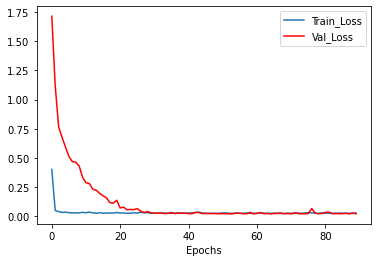

In [408]:
ax = plt.gca()

loss.plot(kind='line', y='Train_Loss', xlabel = 'Epochs',ax=ax)
loss.plot(kind='line', y='Val_Loss', xlabel = 'Epochs', color='red', ax=ax)

loss.plot()           #to plot the loss values
plt.xlabel('Epoch')
plt.ylabel('Loss')

model.summary()

# Predictions

In [464]:
#testing  input data
test_indata = pd.ExcelFile("C:\\Users\\Soongsil Univ\\Documents\\Pradyumna\\NASA Cells\\Train Samples\\Testing\\Charge Input-38.xlsx")
# testing output data
test_outdata =  pd.read_excel("C:\\Users\\Soongsil Univ\\Documents\\Pradyumna\\NASA Cells\\Train Samples\\Testing\\Capacity Output-38.xlsx", header=None)

In [465]:
 # Creating partial charge curves data for Testing Data 

test_data_in = {}              # new empty dictionary
for sheet in test_indata.sheet_names:
    test_data_in[sheet] = pd.read_excel(test_indata, sheet) # Storing the total data sheet by sheet into a dictionary   

seed(50)             # to get same random number always
test_input = {}           # new empty dictionary
for sheet in test_data_in:
    p = round(uniform(0.2, 0.8), 2)                  # generate a random number between 0.2 and 0.8 with 2 decimal places
    length = int(round(test_data_in[sheet].shape[0] * p, 0))  # get the number of rows to be obtained with the percentage value of 'p'
    start = randint(0, test_data_in[sheet].shape[0] - length) # selecting a random row number to start taking the rows   
    test_input[sheet] = test_data_in[sheet].loc[test_data_in[sheet].index[start:start + length], :] # copying the rows into another dictionary 

copy2 = test_input.copy()      # making a copy of the dictionary 'input_data' 

In [466]:
# Creating test input data for testing with data taken from 1st row of each of the 25 segments

for sheet in test_input:
    x = ( round((len(test_input[sheet]))/4) ) 
                                             

    test_input[sheet] = test_input[sheet][0::x]   
    test_input[sheet]['D'] = ""  

C:\Users\SOONGS~1\AppData\Local\Temp/ipykernel_792/2994137917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[sheet]['D'] = ""


In [467]:
# Test Data -  Adding dv/dt in the new column 'D' for each segment  

for sheet in copy2:    
        l = ( round((len(copy2[sheet]))/4) )
        
        for j in range (1,5):
            if j == 4:
                m = copy2[sheet]['Time'].iloc[-1]       # get the last value in time coulmn in the sheet from copy1 dictionary
                n = test_input[sheet]['Time'].iloc[-1] # get the last value in time coulmn in the sheet from train_input 
                v = copy2[sheet]['Voltage'].iloc[-1] - test_input[sheet]['Voltage'].iloc[-1]    #dv
                t = m-n    #dt 
            else:
                m = copy2[sheet]['Time'].iloc[j*l-1]   # get the last value from the time column of the jth segment 
                n = test_input[sheet]['Time'].iloc[j-1] # get the 1st value from the time column of the jth segment
                v = copy2[sheet]['Voltage'].iloc[j*l-1] - test_input[sheet]['Voltage'].iloc[j-1]   #dv
                t = m-n   #dt
            if v==0:
                dv = 0.0001
            else:
                dv = v
            if t==0:
                dt = 1
            else:
                dt = t
          
            test_input[sheet]['D'].iloc[j-1] = dv/dt   # for every segment, store dv/dt value in the column 'D'
            
            
for sheet in test_input: 
    test_input[sheet] = test_input[sheet].drop('Time',axis=1)
    test_input[sheet] = test_input[sheet].iloc[0:4]           # to ensure there are only 4 values in each sheet 
    test_input[sheet] = test_input[sheet][["Voltage","D","Current","Temperature"]]
test_input 

C:\Users\Soongsil Univ\anaconda3\envs\Pradyumna\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


{'Sheet1':        Voltage         D   Current  Temperature
 545   4.174836  0.000018  1.477398    27.428363
 1008  4.199247       0.0  0.736667    27.463987
 1471  4.199292       0.0  0.356065    25.218986
 1934  4.199598 -0.000001  0.176982    26.321108,
 'Sheet2':        Voltage         D   Current  Temperature
 993   4.197637  0.000001  0.545811    27.276794
 1383  4.198708  0.000001  0.296782    26.142801
 1773  4.199583 -0.000003  0.161056    25.801712
 2163  4.196400  0.000001  0.072205    25.467835,
 'Sheet3':        Voltage         D   Current  Temperature
 675   4.199050      -0.0  1.066307    28.742468
 1240  4.198359  0.000001  0.348514    26.282191
 1805  4.199433 -0.000002  0.138695    26.174668
 2370  4.196050 -0.000004  0.049939    26.248151,
 'Sheet4':        Voltage         D   Current  Temperature
 1299  4.199829       0.0  0.291640    26.425380
 1522  4.200048 -0.000001  0.199678    25.753006
 1745  4.199563  0.000002  0.139008    26.214087
 1968  4.200982 -0.000003 

In [468]:
for sheet in test_input:
    test_input[sheet] = test_input[sheet].to_numpy()

for sheet in test_input:
    test_input[sheet] = np.expand_dims((test_input[sheet]), -1)

In [469]:
pred_inp = np.empty((len(test_input.keys()), *test_input['Sheet1'].shape))

for i, k in enumerate(test_input.keys()):
    pred_inp[i] = test_input[k]

print(pred_inp.shape) 

(46, 4, 4, 1)


In [449]:
model = load_model('NASAData Model-1.h5')

In [470]:
predictions = model.predict(pred_inp)

True_value = pd.DataFrame(test_outdata)
True_value = True_value.reset_index(drop=True)
predected_value = pd.DataFrame(predictions)
Error = predected_value - True_value
Error = Error.abs()  # converts -ve numbers into +ve

compare = pd.concat([True_value,predected_value,Error],axis=1)
compare.columns = ['True_value','predected_value','Error']
compare

,True_value,predected_value,Error
0,1.102624,1.596192,0.493568
1,1.088580,1.549045,0.460465
2,1.061325,1.595422,0.534097
3,1.034706,1.541743,0.507037
4,1.026998,1.551194,0.524197
5,1.078502,1.563668,0.485166
6,1.063890,1.631623,0.567734
7,1.036655,1.620362,0.583707
8,1.030941,1.586498,0.555557
9,1.014008,1.612381,0.598373


In [471]:
Error.max() 

0    0.598373
dtype: float64

In [472]:
mean_absolute_error(test_outdata,predictions)

0.18102002534750294

In [473]:
np.sqrt(mean_squared_error(test_outdata,predictions)) #RMS error

0.27164060146446634

In [335]:
#model.save('NASAData Model-1.h5')    # pred -- rms-0.06 max-0.128 mean-0.052      train-0.037  val-0.0248  b.s= 64

In [388]:
#model.save('NASAData Model-2.h5')    # pred -- rms-0.13 max-0.33 mean-0.11      train-0.037  val-0.0248  b.s= 32

In [54]:
#loss.to_excel("metricsRandom.xlsx")

In [55]:
#compare.to_excel("predictionsRandom.xlsx")